# Tutorial - Initial Conditions

While working with respy, you often want to simulate the effects of policies in counterfactual environments.

to do at least one of the following points:

- Individuals should start with nonzero years of experience for some choice.
- The previous (lagged) choice in the first period can only be a subset of all choices in the model.
- An observed characteristic is not evenly distributed in the population.

Taken together these assumptions are called the initial conditions of a model. An initial condition is also called a *seed value* and determines the value of a variable in the first period of a dynamic system. 

In the following, we describe how to set the initial condition for each of the the three points for a small Robinson Crusoe Economy. A more thorough presentation of a similar model can be found [here](tutorial-robinson-crusoe.ipynb).

In [1]:
%matplotlib inline

import io
import pandas as pd
import respy as rp
import matplotlib.pyplot as plt
import seaborn as sns

## Experiences

In a nutshell, Robinson can choose between fishing and staying in the hammock every period. He can accumulate experience in fishing which makes him more productive. To describe such a simple model, we write the following parameterization and simulate data with ten periods.

In [2]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.01
nonpec_hammock,constant,1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,0
"""

options = {
    "n_periods": 10,
    "simulation_agents": 1_000,
    "covariates": {"constant": "1"}
}

In [3]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category       name                       
delta          delta                  0.95
wage_fishing   exp_fishing            0.01
nonpec_hammock constant               1.00
shocks_sdcorr  sd_fishing             1.00
               sd_hammock             1.00
               corr_hammock_fishing   0.00

In [4]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

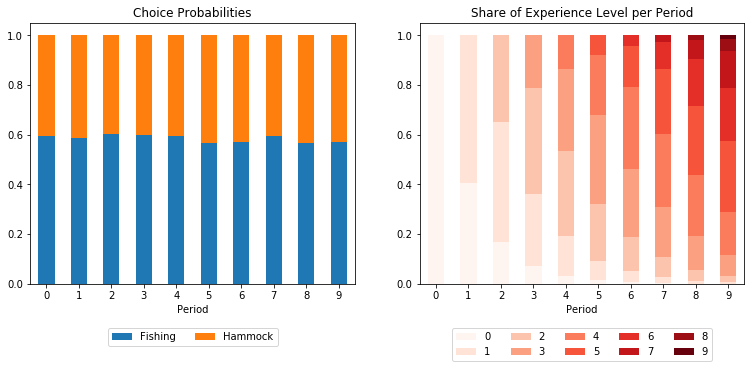

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

(df.groupby("Period").Choice.value_counts(normalize=True).unstack()
 .plot.bar(ax=axs[0], stacked=True, rot=0, title="Choice Probabilities"))
(df.groupby("Period").Experience_Fishing.value_counts(normalize=True).unstack().plot
 .bar(ax=axs[1], stacked=True, rot=0, title="Share of Experience Level per Period", cmap="Reds"))

axs[0].legend(["Fishing", "Hammock"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=5)

plt.show()
plt.close()

The figure on the left-hand-side shows the choice probabilities for Robinson in each period. On the right-hand-side, one can see the average experience in fishing. By default Robinson starts with zero experience in fishing.

What if Robinson has an equal probability start with zero, one or two periods of experience in fishing? The first way to add more complex initial conditions to the model is via **probability mass functions**. This type of distributions is handy if the probabilities do not depend on any information. To feed the information to ``respy`` use the keyword ``initial_exp_fishing_*`` in the category-level of the index. Replace ``*`` with the experience level. In the name-level, use ``probability`` to signal that the float in ``value`` is a probability. The new parameter specification is below.

Note that one probability is set to 0.34 such that all probabilities sum to one. If that is not the case, respy will emit a warning and normalize probabilities.

In [6]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.01
nonpec_hammock,constant,1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,0
initial_exp_fishing_0,probability,0.33
initial_exp_fishing_1,probability,0.33
initial_exp_fishing_2,probability,0.34
"""

In [7]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category              name                       
delta                 delta                  0.95
wage_fishing          exp_fishing            0.01
nonpec_hammock        constant               1.00
shocks_sdcorr         sd_fishing             1.00
                      sd_hammock             1.00
                      corr_hammock_fishing   0.00
initial_exp_fishing_0 probability            0.33
initial_exp_fishing_1 probability            0.33
initial_exp_fishing_2 probability            0.34

In [8]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

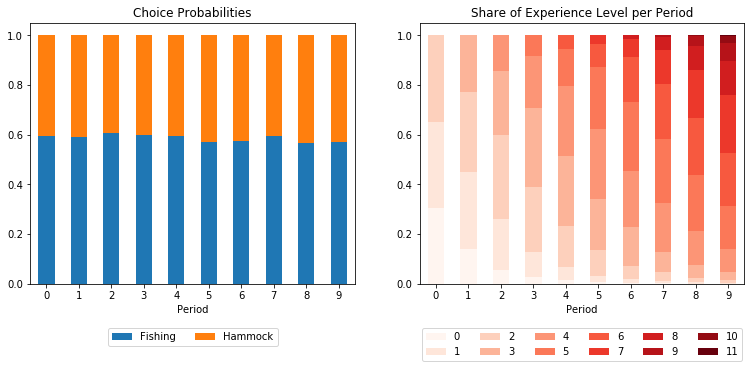

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

(df.groupby("Period").Choice.value_counts(normalize=True).unstack()
 .plot.bar(ax=axs[0], stacked=True, rot=0, title="Choice Probabilities"))
(df.groupby("Period").Experience_Fishing.value_counts(normalize=True).unstack().plot
 .bar(ax=axs[1], stacked=True, rot=0, title="Share of Experience Level per Period", cmap="Reds"))

axs[0].legend(["Fishing", "Hammock"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

plt.show()
plt.close()

One can clearly see the proportions of experiences in the first period.

## Lagged Choices

In the next step, we want to enrich the model with information on the choice in the previous period. Let us assume that Robinson has troubles storing food on a tropical island so that he incurs a penalty if he enjoys his life in the hammock two times in a row. We add the parameter ``"not_fishing_last_period"`` to the nonpecuniary reward and add a corresponding covariate to the options.

In [10]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.01
nonpec_hammock,constant,1
nonpec_hammock,not_fishing_last_period,-0.5
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,0
initial_exp_fishing_0,probability,0.33
initial_exp_fishing_1,probability,0.33
initial_exp_fishing_2,probability,0.34
"""

options = {
    "n_periods": 10,
    "simulation_agents": 1_000,
    "covariates": {
        "constant": "1",
        "not_fishing_last_period": "lagged_choice_1 != 'fishing'"
    }
}

In [11]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category              name                          
delta                 delta                     0.95
wage_fishing          exp_fishing               0.01
nonpec_hammock        constant                  1.00
                      not_fishing_last_period  -0.50
shocks_sdcorr         sd_fishing                1.00
                      sd_hammock                1.00
                      corr_hammock_fishing      0.00
initial_exp_fishing_0 probability               0.33
initial_exp_fishing_1 probability               0.33
initial_exp_fishing_2 probability               0.34

In [12]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

C:\Users\tobia\git\respy\respy\pre_processing\model_processing.py:470: UserWarning: The distribution of initial lagged choices is insufficiently specified in the parameters. Covariates require 1 lagged choices and parameters define 0. Missing lags have equiprobable choices.
  category=UserWarning,
C:\Users\tobia\git\respy\respy\pre_processing\model_processing.py:470: UserWarning: The distribution of initial lagged choices is insufficiently specified in the parameters. Covariates require 1 lagged choices and parameters define 0. Missing lags have equiprobable choices.
  category=UserWarning,


Below we see the choice probabilities on the left-hand-side and the shares of lagged choices on the right-hand-side. Without further information, ``respy`` makes all previous choices in the first period equiprobable.

If we had set the covariate with the lagged choice but not added a parameter using the covariate, ``respy`` would have discarded the covariate and created a model without lagged choices.

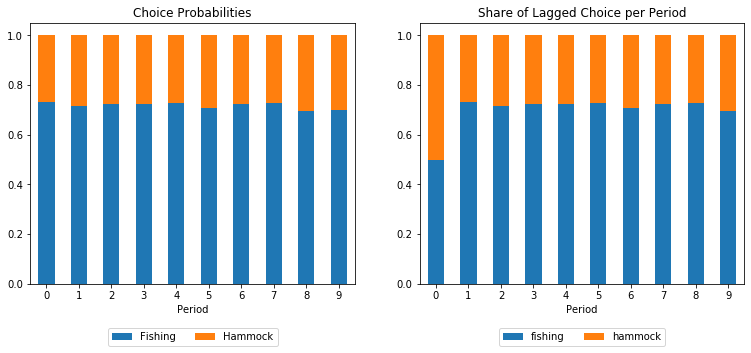

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

(df.groupby("Period").Choice.value_counts(normalize=True).unstack()
 .plot.bar(ax=axs[0], stacked=True, rot=0, title="Choice Probabilities"))
(df.groupby("Period").Lagged_Choice_1.value_counts(normalize=True).unstack().plot
 .bar(ax=axs[1], stacked=True, rot=0, title="Share of Lagged Choice per Period"))

axs[0].legend(["Fishing", "Hammock"], loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.show()
plt.close()

What if we wanted a more complex distribution of lagged choices. Remember that Robinson starts with 0, 1 or 2 periods of experience in fishing. Thus, it is natural to assume that higher experience levels correspond to a higher probability for having fishing as a previous choice.

This kind of distribution is more complex because it involves covariates. A flexible solution is to use a **multinomial logit** or **softmax function** to map parameters with covariates to probabilities. This allows to specify very complex distributions, ones which could have been estimated outside the structural model. Here is a short explanation.

For each lag, we have a set of parameters, $\beta^f$ and $\beta^h$, and their corresponding covariates, $x^f$ and $x^h$. The probability $p^f$ for one individual having fishing as their first lagged choice is

$$
    p^f = \frac{e^{x^f \beta^f}}{e^{x^f \beta^f} + e^{x^h \beta^h}}
$$

The probability for hammock as the lagged choice is defined analogously.

In the parameters, you can use the ``lagged_choice_1_fishing`` keyword to define the parameters for fishing as the first lag. You can also define higher order lags using, for example, ``lagged_choice_2_*``.

Let us assume that with each level of initial experience the probability for choosing fishing the previous period rises from 0.5 over 0.75 to 1. For zero experience in fishing, the resulting probabilities should be one halve for fishing and one halve for hammock. First, we create a covariate which is ``True`` if an individual has zero experience in fishing. This covariate is ``{"zero_exp_fishing": "exp_fishing == 0"}``. Then, the parameters for this covariate just have to be equal and can take any value. That is because the softmax function is shift-invariant. The resulting lines in the csv are

    lagged_choice_1_fishing,zero_exp_fishing,1
    lagged_choice_1_hammock,zero_exp_fishing,1
    
For one level of experience, the weights are 0.75 for fishing and 0.25 for the hammock. First, define a covariate ``{"one_exp_fishing": "exp_fishing == 1"}``. To get the corresponding softmax coefficients for the probabilities, note that you can rewrite the softmax formula setting the covariates to constants. Recognize that the sum in the denominator, $C$, applies to all probabilities and can be discarded. Thus, the coefficients are the logs of the probabilities.

$$\begin{align}
    p_i      &= \frac{e^{x_i \beta_i}}{\sum_j e^{x_j \beta_j}} \\
             &= \frac{e^{\beta_i}}{\sum_j e^{\beta_j}} \\
    log(p_i) &= \beta_i - \log(\sum_j e^{\beta_j}) \\
             &= \beta_i - C
\end{align}$$

The lines in the parameters for $log(0.75)$ and $log(0.25)$ are

    lagged_choice_1_fishing,one_exp_fishing,-0.2877
    lagged_choice_1_hammock,one_exp_fishing,-1.3863
    
For two experience in fishing, we have to make sure that fishing receives a probability of one which can be achieved by using a fairly large value such as 6. By default, all missing choices receive a parameter with value -1e300.

The final parameters and options are the following:

In [14]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.01
nonpec_hammock,constant,1
nonpec_hammock,not_fishing_last_period,-0.5
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,0
initial_exp_fishing_0,probability,0.33
initial_exp_fishing_1,probability,0.33
initial_exp_fishing_2,probability,0.34
lagged_choice_1_fishing,zero_exp_fishing,1
lagged_choice_1_hammock,zero_exp_fishing,1
lagged_choice_1_fishing,one_exp_fishing,-0.2877
lagged_choice_1_hammock,one_exp_fishing,-1.3863
lagged_choice_1_fishing,two_exp_fishing,6
"""

options = {
    "n_periods": 10,
    "simulation_agents": 10_000,
    "covariates": {
        "constant": "1",
        "not_fishing_last_period": "lagged_choice_1 != 'fishing'",
        "zero_exp_fishing": "exp_fishing == 0",
        "one_exp_fishing": "exp_fishing == 1",
        "two_exp_fishing": "exp_fishing == 2",
    }
}

In [15]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category                name                           
delta                   delta                    0.9500
wage_fishing            exp_fishing              0.0100
nonpec_hammock          constant                 1.0000
                        not_fishing_last_period -0.5000
shocks_sdcorr           sd_fishing               1.0000
                        sd_hammock               1.0000
                        corr_hammock_fishing     0.0000
initial_exp_fishing_0   probability              0.3300
initial_exp_fishing_1   probability              0.3300
initial_exp_fishing_2   probability              0.3400
lagged_choice_1_fishing zero_exp_fishing         1.0000
lagged_choice_1_hammock zero_exp_fishing         1.0000
lagged_choice_1_fishing one_exp_fishing         -0.2877
lagged_choice_1_hammock one_exp_fishing         -1.3863
lagged_choice_1_fishing two_exp_fishing          6.0000

In [16]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

The parameters produce previous choice probabilities on the left-hand-side and the correct conditional probabilities on the right-hand-side. Unfortunately, the conditional probabilities are even slightly off for 10,000 simulated individuals.

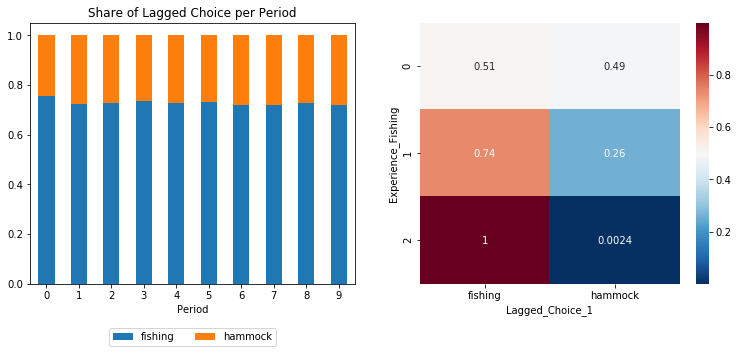

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

(df.groupby("Period").Lagged_Choice_1.value_counts(normalize=True).unstack().plot
 .bar(ax=axs[0], stacked=True, rot=0, title="Share of Lagged Choice per Period"))

sns.heatmap((df.query("Period == 0").groupby(["Experience_Fishing"]).Lagged_Choice_1
 .value_counts(normalize="rows").unstack().fillna(0)), ax=axs[1], cmap="RdBu_r", annot=True)

axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=6)

plt.show()
plt.close()

## Observables

Now, we have talked enough about experiences and lagged choices. The last section is about observables which are other characteristics such as whether the island has rich fishing grounds or not. We can also express the distribution of observables as probability mass functions or softmax functions.

Note that observables are sampled first before all other characteristics of individuals. After that, experiences and lagged choices in chronological order (highest lag first) follow. Every group itself is sorted alphabetically. Keep this in mind if you want to condition a distribution on other characteristics.

For observables, it is also possible to use labels instead of numbers to identify levels which might be more convenient and intuitive. The evenly distributed levels are ``"rich"`` and ``"poor"``. The keyword is ``observable_*_*`` and everything after the last ``_`` is considered the name of the level.

In [42]:
params = """
category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.01
nonpec_fishing,rich_fishing_grounds,0.5
nonpec_hammock,constant,1
nonpec_hammock,not_fishing_last_period,-0.5
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,0
initial_exp_fishing_0,probability,0.33
initial_exp_fishing_1,probability,0.33
initial_exp_fishing_2,probability,0.34
lagged_choice_1_fishing,zero_exp_fishing,1
lagged_choice_1_hammock,zero_exp_fishing,1
lagged_choice_1_fishing,one_exp_fishing,-0.2877
lagged_choice_1_hammock,one_exp_fishing,-1.3863
lagged_choice_1_fishing,two_exp_fishing,6
observable_fishing_grounds_rich,probability,0.5
observable_fishing_grounds_poor,probability,0.5
"""

options = {
    "n_periods": 10,
    "simulation_agents": 10_000,
    "covariates": {
        "constant": "1",
        "not_fishing_last_period": "lagged_choice_1 != 'fishing'",
        "zero_exp_fishing": "exp_fishing == 0",
        "one_exp_fishing": "exp_fishing == 1",
        "two_exp_fishing": "exp_fishing == 2",
        "rich_fishing_grounds": "fishing_grounds == 'rich'",
    }
}

In [43]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category                        name                           
delta                           delta                    0.9500
wage_fishing                    exp_fishing              0.0100
nonpec_fishing                  rich_fishing_grounds     0.5000
nonpec_hammock                  constant                 1.0000
                                not_fishing_last_period -0.5000
shocks_sdcorr                   sd_fishing               1.0000
                                sd_hammock               1.0000
                                corr_hammock_fishing     0.0000
initial_exp_fishing_0           probability              0.3300
initial_exp_fishing_1           probability              0.3300
initial_exp_fishing_2           probability              0.3400
lagged_choice_1_fishing         zero_exp_fishing         1.0000
lagged_choice_1_hammock         zero_exp_fishing         1.0000
lagged_choice_1_fishing         one_exp_fishing         -0.2877
lagged_choice_1_hammock         one_exp_fishing         -1.3863
lagged_choice_1_fishing         two_exp_fishing          6.0000
observable_fishing_grounds_rich probability              0.5000
observable_fishing_grounds_poor probability              0.5000

In [44]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

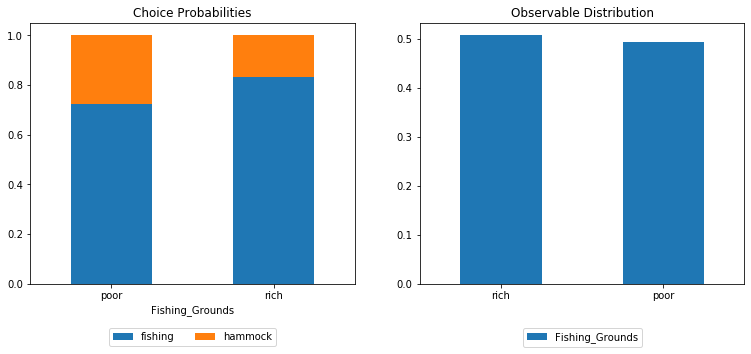

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12.8, 4.8))

(df.groupby("Fishing_Grounds").Choice.value_counts(normalize=True).unstack().plot
 .bar(ax=axs[0], stacked=True, rot=0, title="Choice Probabilities"))

(df.Fishing_Grounds.value_counts(normalize=True)
 .fillna(0).plot.bar(stacked=True, ax=axs[1], rot=0, title="Observable Distribution"))

axs[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
axs[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.show()
plt.close()

You can see in the figure on the right-hand-side that poor and rich fishing grounds are evenly distributed. The figure on the left-hand-side shows that rich fishing grounds lead to higher engagement in fishing.

## Conclusion

We showed ...

- how to express different distributions, probability mass functions or softmax functions, in the parameters of a respy model.
- that you can use numbers and labels for discrete levels of observables.

Happy modeling!